In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from cmdstanpy import CmdStanModel
from sklearn.metrics import mean_squared_error

In [3]:
# Importing data
df_ceny: pd.DataFrame = pd.read_csv("PL_CENY_NIEZB_RB_20230301_20230331_20230514120846.csv", sep=";", decimal=",")
df_zapotrzebowanie: pd.DataFrame = pd.read_csv("PL_WYK_KSE_20230301_20230331_20230401010553.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny["Data_i_Godzina"] = df_ceny["Data"].astype(str) + " - " + df_ceny["Godzina"].astype(str)
df_ceny = df_ceny[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data"].astype(str) + " - " + df_zapotrzebowanie["Godzina"].astype(str)
df_zapotrzebowanie["Dzień tygodnia"] = df_zapotrzebowanie["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_pogoda: pd.DataFrame = pd.read_csv("k_d_t_03_2023.csv", encoding="cp1250", parse_dates=[[2, 3, 4]], header=None)
df_pogoda = df_pogoda.set_axis(["Data", "Kod stacji", "Nazwa", "Temperatura", "Status temp", "Wilgotność", "Status wil",
                    "Prędkość wiatru", "Status pr", "Zachmurzenie", "Status zach"], axis=1)
df_pogoda = df_pogoda.loc[(df_pogoda["Status temp"] != 8.0) & (df_pogoda["Status pr"] != 8.0)]
df_pogoda = df_pogoda[["Data", "Temperatura", "Prędkość wiatru"]]
df_pogoda = df_pogoda.groupby("Data").mean().reset_index()
df_pogoda.set_index("Data", inplace=True)

24877.138
13737.788


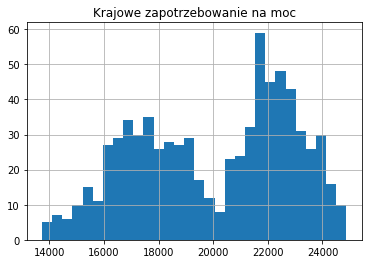

In [4]:
df_zapotrzebowanie.hist("Krajowe zapotrzebowanie na moc", bins=30)
print(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].max())
print(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].min())
plt.show()

(96, 2)


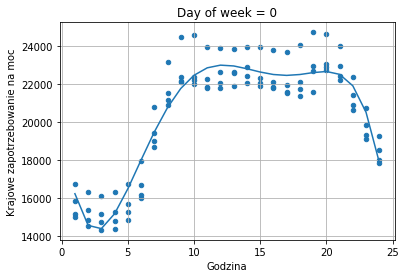

[-9.50703760e-02  6.14994947e+00 -1.45486338e+02  1.47470424e+03
 -5.15813662e+03  2.00598441e+04]
(96, 2)


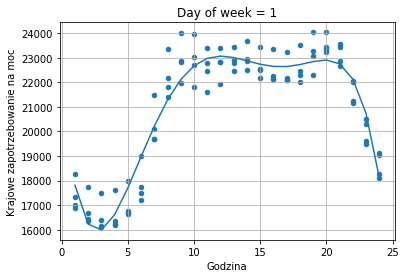

[-8.78203160e-02  5.62519133e+00 -1.31871194e+02  1.33029756e+03
 -4.72911895e+03  2.13324030e+04]
(120, 2)


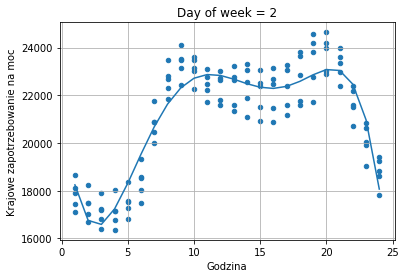

[-9.63035781e-02  6.04350114e+00 -1.37821128e+02  1.34536611e+03
 -4.64844525e+03  2.16833403e+04]
(120, 2)


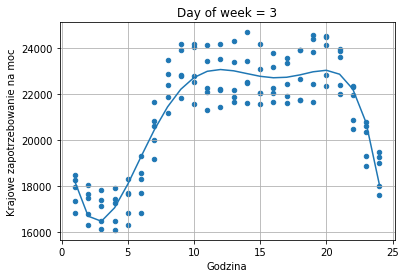

[-8.57723180e-02  5.45456535e+00 -1.26952039e+02  1.27263620e+03
 -4.51004698e+03  2.15381083e+04]
(120, 2)


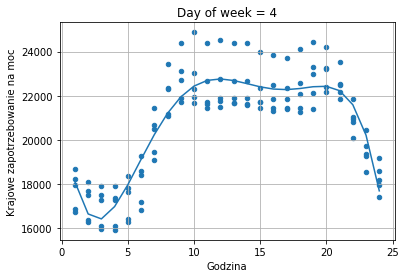

[-8.10986775e-02  5.18096566e+00 -1.21186825e+02  1.21985827e+03
 -4.33987823e+03  2.13388750e+04]
(96, 2)


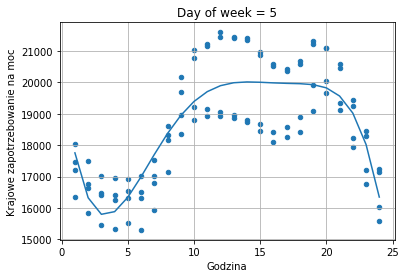

[-4.80872995e-02  3.15380473e+00 -7.73493888e+01  8.41564212e+02
 -3.45906662e+03  2.04476010e+04]
(95, 2)


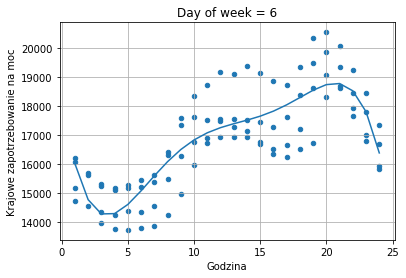

[-4.48080230e-02  2.84113231e+00 -6.70128103e+01  7.10661245e+02
 -2.94640244e+03  1.83230422e+04]


In [5]:
# Regression
for day in range(7):
    data = df_zapotrzebowanie[["Godzina", "Krajowe zapotrzebowanie na moc"]].loc[df_zapotrzebowanie["Dzień tygodnia"] == day]
    print(data.shape)
    x = data["Godzina"]
    data.plot(x="Godzina", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
    plt.title(f"Day of week = {day}")
    coef = np.polyfit(x, data["Krajowe zapotrzebowanie na moc"], 5)  # Degree
    p = np.poly1d(coef)
    x = np.sort(x.drop_duplicates().to_numpy())
    plt.plot(x, p(x))
    plt.show()
    print(coef)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing


    lp__  accept_stat__  coeffs[1,1]  coeffs[2,1]  coeffs[3,1]  coeffs[4,1]  \
0    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
1    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
2    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
3    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
4    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
5    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
6    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
7    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
8    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
9    0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
10   0.0            0.0     -0.09507     -0.08782    -0.096304    -0.085772   
11   0.0            0.0     -0.09507     -0.08782   

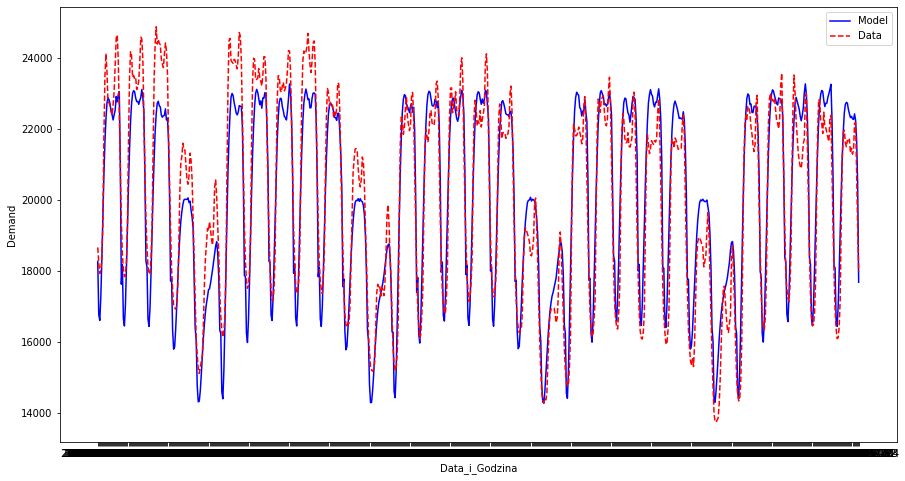

RMSE = 947.9026166290081


In [14]:
# Prior
model_ppc=CmdStanModel(stan_file='model1.stan')
ppc = model_ppc.sample(show_progress=False, data=dict(
    N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values
    ))
df_ppc = ppc.draws_pd()
print(df_ppc.head(50))
df_ppc_mean = df_ppc.mean()[[f"demand[{i}]" for i in range(1, 744)]]
print(df_ppc_mean.head(50).to_numpy())
plt.figure(figsize=(15, 8))
plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean, "b-",
         df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
plt.xlabel("Data_i_Godzina")
plt.ylabel("Demand")
plt.legend(["Model", "Data"])
plt.show()
print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean.values, squared=False)}')

INFO:cmdstanpy:found newer exe file, not recompiling


nu = 1


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing


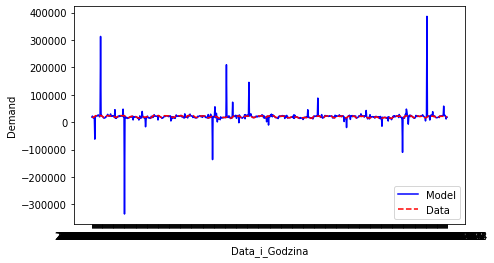

RMSE = 25279.30726264601
nu = 2


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


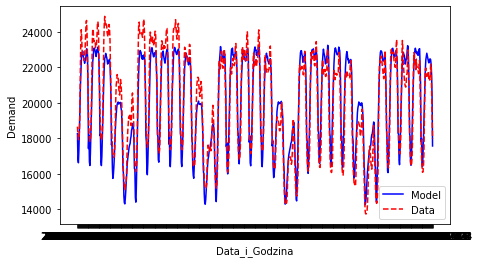

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


RMSE = 942.9428405487365
nu = 3


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


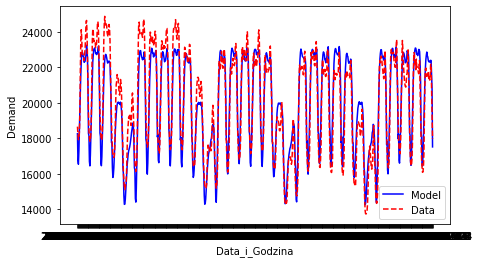

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


RMSE = 940.2113907588744
nu = 5


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


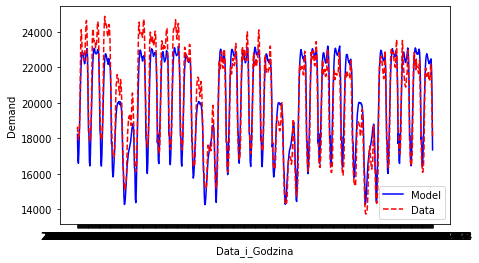

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


RMSE = 943.638062252472
nu = 10


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


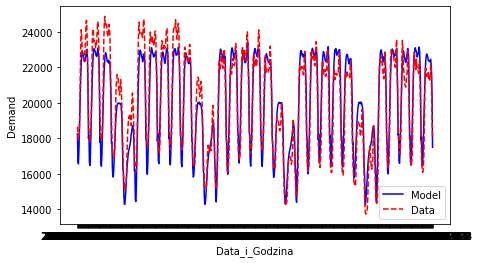

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


RMSE = 944.7723318430938
nu = 100


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


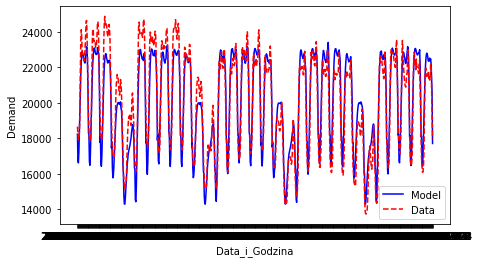

RMSE = 946.0863096031932


In [21]:
# Prior 2
model_ppc2=CmdStanModel(stan_file='model2.stan')
for nu in [1, 2, 3, 5, 10, 100]:
    print(f"nu = {nu}")
    ppc2 = model_ppc2.sample(show_progress=False, data=dict(
        N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, nu=nu
        ))
    df_ppc2 = ppc2.draws_pd()
    df_ppc_mean2 = df_ppc2.mean()[[f"demand[{i}]" for i in range(1, 744)]]
    plt.figure(figsize=(7, 4))
    plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean2, "b-",
            df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
    plt.xlabel("Data_i_Godzina")
    plt.ylabel("Demand")
    plt.legend(["Model", "Data"])
    plt.show()
    print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean2.values, squared=False)}')